In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

BURN_IN = 1000


def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

This file is based on the class materials of AEROSP 567 taught by Prof. Alex Gorodetsky at University of Michigan. 
Author: Hung-Hsiang Liang

# 1 First Example: Comparing 4 variants of Metropolis-Hastings Markov Chain Monte Carlo simulation using "Banana Function"

In this section, we will demostrate 4 different variants of Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC)simulation algorithms using "Banana Function". They are:

1. Ordinary MH-MCMC
2. Adaptive Metropolis MCMC (AM-MCMC)
3. Delayed Rejection MCMC (DR-MCMC)
4. Delayed-Rejection and Adaptive Metropolis MCMC (DRAM-MCMC).

## 1-1 Metropolis-Hastings Markov Chain Monte Carlo

The Metropolis-Hasting Markov Chain Monte Carlo simulation includes the following steps:

1. Propose sample y
2. Compute acceptance probability
3. Accept or reject sample y
4. Repeat

Where the acceptance probability is defined as follows:

\begin{equation}
a(x^{(k)}, y) = \min \left\{ \frac{f_X(y)}{f_X(x^{(k)})} \frac{q(x^{(k)} \mid y)}{q(y \mid x^{(k)})}, \  1 \right\}
\end{equation}

It's more convenient to compute the log-probability:

\begin{equation}
\tilde{a}(x^{(k)}, y) = \min \left\{ \log f_X(y) - \log f_X(x^{(k)}) + \log q(x^{(k)} \mid y) - \log q(y \mid x^{(k)}), \  0 \right\}
\end{equation}

In [2]:
def mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf, current_sample, proposed_sample, proposal_func):
    """Compute the metropolis-hastings accept-reject probability
    
    Inputs
    ------
    current_target_logpdf : float, logpdf at the current sample in the chain f_X(x^{(k)})
    proposed_target_logpdf : float, logpdf at the proposed sample in the chain
    current_sample : (d, ), current sample
    proposed_sample : (d, ), proposed sample
    proposal_func: f(x, y) callable that gives the log probability of y given x
    
    Returns
    -------
    acceptance probability
    """
    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1        

The MHMCMC algorithm is implemented in the following function:

In [3]:
def mhmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, init_cov=3e-1**2):
    """Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    I_d = np.eye(d)
    sd = 2.4**2/d
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    
    if np.size(init_cov) == 1:
        sk = init_cov*I_d # covarance
    else:
        sk = sd*init_cov
    sk_chol = np.linalg.cholesky(sk)
    proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], sk_chol)
        proposed_target_logpdf = target_logpdf(proposed_sample)
        
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf_given_cov)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :] = samples[ii-1, :]
                
    return samples, num_accept / float(num_samples-1)

### Random Walk Proposal

We first consider a random walk proposal proposes the next step according to a random walk

\begin{equation}
Y = x^{(k)} + \xi,
\end{equation}

where $\xi \sim \mathcal{N}(0, \Gamma)$ for a Gaussian random walk with some covariance $\Gamma$. In other words, the proposal is 

\begin{equation}
q(y \mid x) = \frac{1}{2\pi^{d/2}|\Gamma|^{1/2}} \exp\left( -\frac{1}{2} \lVert y - x^{(k)} \rVert_{\Gamma}^2 \right)
\end{equation}

There is some theory (derived for a Gaussian target distribution) that suggests an "optimal" covariance

\begin{equation}
\Gamma = \left(\frac{2.38}{\sqrt{d}}\right)^2 \Sigma,
\end{equation}

where $\Sigma$ is the true covariance of the target distribution. 

Another rule of thumb is that a good proposal distribution will typically result in 20-30% of the proposed samples being accepted. 

Finally, if the proposal is only function of the distance between $y$ and $x$ $q(y \mid x) = q(|y - x|)$, such as the Gaussian random walk proposal given above, then the acceptance probability simplifies to 

\begin{equation}
a(x, y) = \min\left\{ 1, \frac{f_X(y)}{f_X(x)} \right\}
\end{equation}


In [4]:
def proposal_rw_sampler(x, std=1.0):
    """Sample from a random walk proposal with identity covariance"""
    y = std*np.random.randn(x.shape[0]) + x
    return y

def proposal_rw_logpdf(x, y, std=1.0):
    """Probability of moving from x to y (in this case it is symmetric)"""
    delta = x - y
    logpdf = -0.5*np.dot(delta, delta)/std/std
    return logpdf

In [5]:
def proposal_rw_sampler_with_cov(x, std_chol):
    """Sample from a random walk proposal with whatever covariance"""
    d = x.shape[0]
    y = x + np.dot(std_chol, np.random.randn(d))
    return y

def proposal_rw_logpdf_with_cov(x, y, cov):
    """Probability of moving from x to y (in this case it is symmetric)"""
    """log PDF of a Multivariate Gaussian Random Variable
    
    Inputs
    --------
    x: (n, 1) column vector of start point
    y: (n, 1) column vector of end point
    cov: (n, n) array denoting the covariance
    
    Returns
    --------
    out: (N) array of pdf at each input x
    """
    n = x.shape[0]
    
    # Compute the pre-exponential factor
    preexp = 1.0 / (2.0 * np.pi)**(n/2) / np.linalg.det(cov)**0.5

    # Compute the difference between the inputs x and the mean
    # This difference has size n X N
    diff = x - y
    diff = np.reshape(diff, [n, 1])
    
    # We now need to compute 
    # Compute sol = \Sigma^{-1} diff, sol is now n X N (Sigma * sol = diff)
    sol = np.linalg.solve(cov, diff)
    
    # we now need to take the dot product of each column of diff and sol
    # equivalent of the below (but much much much faster for large N)
    #for ii in range(N):
    #    inexp[ii] = np.dot(diff[:, ii], sol[:, ii])
    
    inexp = np.dot(diff.T, sol)
    
    logpdf = np.log(preexp) - 0.5 * inexp
    return logpdf

### "Banana Function"

\begin{equation}
\log f_X(x,y) =(x)^2 + (y + x^2 + 1)^2
\end{equation}

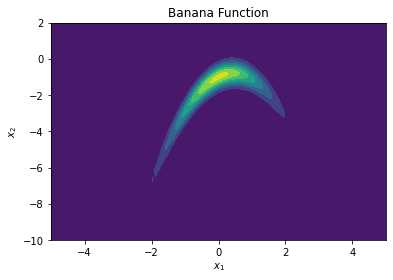

In [6]:
def banana_logpdf(x):
    x_banana = np.array([x[0], x[1]+x[0]**2 + 1])
    gauss_mean = np.array([0, 0])
    gauss_cov = build_cov_mat(1.0, 1.0, 0.9) # std, std, correlation
    
    return lognormpdf(x_banana[:, np.newaxis], gauss_mean, gauss_cov)

def plot_banana():
    plt.figure()
    xgrid = np.linspace(-5, 5, 100)
    ygrid = np.linspace(-10, 2, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    plt.contourf(XX, YY, 
                 eval_func_on_grid(compose(np.exp, banana_logpdf), 
                                   xgrid, ygrid).T)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title("Banana Function")

plot_banana()

### Laplace approximation
To improve the efficiency of the MH-MCMC, we implement Laplace approximation to approximate the posterior with a Gaussian distribution and generate an initial sample and the covariance. The Taylor expansion around some point $x^*$ so that any $x=x^* + \delta x$

\begin{align*}
    \log{f_X(x)} = \log{f_X(x^*)} + \nabla \log{f_X(x)}|_{x=x^*}\delta x + \frac{1}{2} \Delta \log{f_X(x)}|_{x=x^*}\delta x^2 + H.O.T.
\end{align*}

Here, $\Delta$ stands for Hessian. If we choose $x^* = x^{MAP}$, then the second term of the equation above vanishes and we obtain

\begin{align*}
    \log{f_X(x)} \approx \log{f_X(x^{MAP})} + \frac{1}{2} \Delta \log{f_X(x)} (x - x^{MAP})^2 
\end{align*}

We now seek to approximate $f_X(x)$ by some $g_X(x) = N(x^{MAP}, C)$ and we need to find the covariance $C$. From log Gaussian distribution $\log{g_X(x)}$:

\begin{equation}\label{eqn:GaussianApproximate}
    \log{g_X(x)} = \log{\frac{1}{\sqrt{2\pi|C}^{d/2}}} - \frac{1}{2}(x-x^{MAP})^T C^{-1} (x-x^{MAP})
\end{equation}

By comparing $\frac{1}{2}(x-x^{MAP})^T C^{-1} (x-x^{MAP})$ in equation above with $\frac{1}{2} \Delta \log{f_X(x)}|_{x=x^{MAP}} (x - x^{MAP})^2$ in equation prior to the last one, we can set

\begin{equation}
    C^{-1} = -H = -\Delta \log{f_X(x^{MAP})}
\end{equation}

For the random walk proposal, we use

\begin{equation}\label{eqn:rmproposal}
    q(y|x) \sim N(x, S) = N \left( x, \frac{2.4^2}{d} C \right)
\end{equation}

where $d$ is the dimension of the sample space.

In [7]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [8]:
num_samples = 100000
dim = 2
initial_guess = np.random.randn(2) # random location
target_logpdf = banana_logpdf

[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)

samples, ar = mhmcmc(initial_sample, num_samples, target_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)

samples = samples[BURN_IN:, :]

Accepted Samples Ratio: 0.14478144781447813


### Visualization

The samples are visualized and the distribution of the samples are very similar to the banana function.

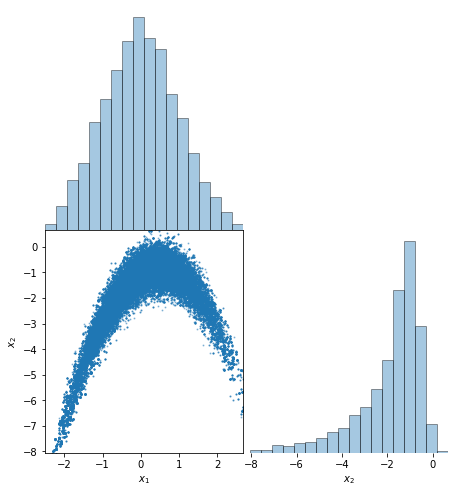

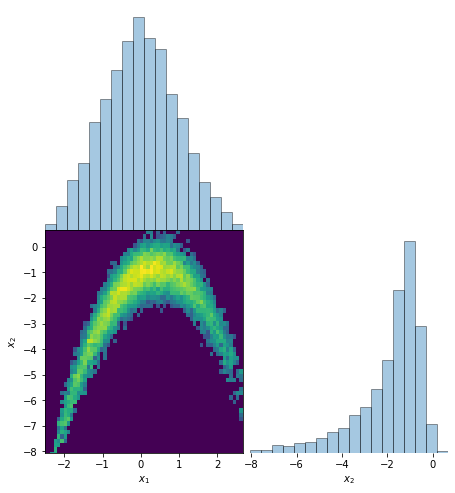

In [9]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### Visual inspection of mixing

Good mixing means that generated have moved around and covered the posterior and therefore its trace plot look like a sample of white noise. A bad samples take small local steps and take a long time to fully explore the distribution.

Text(0.5, 0, 'Sample Number')

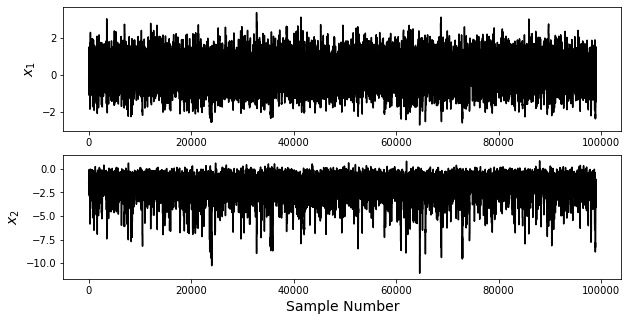

In [10]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation
The autocorrelation describes the correlation the between iterations with $l$ (distance) apart. Autocorrelation converges to 0 when with larger $l$. A rapid convergence is desired such that two samples are more conditional independence at fixed $l$. Autocorrelation $R(l)$ is defined as
\begin{equation}
    R(l) = corr(X_k, X_{k+1}) = \frac{\sum_{i=0}^{n-l}(X_i - \bar{X})(X_{i+1}-\bar{X})}{\sum_{i=0}^{n}(X_i - \bar{X})^2}
\end{equation}

In [11]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

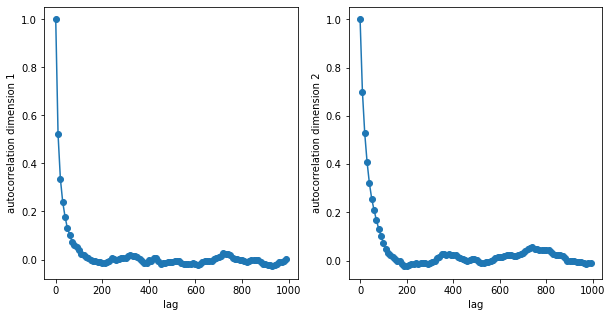

In [12]:
maxlag=1000
step=10
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

### Integrated autocorrelation values (IAC)

Now, we are here to assess the performance of the MCMC. The acceptance ratio is one of the hint of the performance. If the acceptance ratio is too low, the proposal need to be refined as the proposed points may be stocked at some points. The rule of thumb of a good proposal is that the acceptance ratio is around 20\% - 30\%.

The integrated autocorrelation (IAC) is defined as
\begin{equation}
    IAC = 1 + 2\sum_{l=1}^{\infty}corr(f(X_0), f_(X_l)) = \theta
\end{equation}
The greater the IAC, the more inefficient the MCMC is.


In [13]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
print("IAC(x):", IACx)
print("IAC(y):", IACy)

IAC(x): 5.77446993046883
IAC(y): 10.742351802093188


### Effective Sample Size (ESS)

We can define effective sample size (ESS):
\begin{equation}
    ESS = \frac{n}{\theta}
\end{equation}

In [14]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)

ESS(x): 17317.606846015908
ESS(y): 9308.948528432538


## 1-2 Adaptive Metropolis
The algorithm of this section is similar to the ordinary MH-MCMC discussed in previous section. The only difference is we implement Adaptive Metropolis to update the mean and covariance of the proposal recursively.

After we have generated several samples from the corresponding random variables $X_0, X_1, ..., X_{k-1}$, then a candidate point $y$ is sampled from the proposal distribution $q(y|X_0 = x^{(0}), ... X_{k-1}=x^{(k-1)})$, which may depend on whole history. Therefore, the covariance of proposal distribution must be updated according to the past history. For the random walk proposal, we can update the proposal covariance recursively:

\begin{equation}
    S_{k+1} = \frac{k-1}{k}S_k + \frac{s_d}{k} \left[ \xi I + k\bar{x}^{k-1}\bar{x}^{{k-1}^T} - (k + 1) \bar{x}^k \bar{x}^{{k}^T} + x^{(k)}x^{(k)^T} \right]
\end{equation}

where a small $xi = 0.001$ is set throughout this project. And the mean can also be updated with

\begin{equation}
    \bar{x}^k = \frac{1}{k+1}x^{(k)} + \frac{k}{k+1} \bar{x}^{k-1}
\end{equation}

In [15]:
def AMmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, t0=100, freq=1, init_cov=3e-1**2):
    """Adaptive Metropolis MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    t0: integer, start adapting metropolis t0-th step.
    freq: integer, the frequency to adapt metropolis
    
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """
    xi = 0.001
    d = starting_sample.shape[0]
    I_d = np.eye(d)
    sd = 2.4**2/d
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    
    mean_curr = np.reshape(starting_sample, [d, 1]) # mean
    if np.size(init_cov) == 1:
        sk = init_cov*I_d # covarance
    else:
        sk = sd*init_cov
    sk_chol = np.linalg.cholesky(sk)
    proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)
    current_target_logpdf = target_logpdf(samples[0, :])
    
    num_accept = 0
    
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], sk_chol)
        proposed_target_logpdf = target_logpdf(proposed_sample)
        
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf_given_cov)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :] = samples[ii-1, :]
                
        # adapt covariance
        xk = (samples[ii, :])[:, np.newaxis]
        mean_prev = mean_curr
        mean_curr = 1/(ii + 1)*xk + ii/(ii + 1)*mean_prev
        sk = (ii-1)/ii * sk + \
             sd/ii * (xi * I_d + \
                      ii * np.matmul(mean_prev, mean_prev.T) - \
                      (ii + 1) * np.matmul(mean_curr, mean_curr.T) + \
                      np.matmul(xk, xk.T))
        
        if ii > t0 and ii % freq == 0:
            sk_chol = np.linalg.cholesky(sk)
            proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)

        if ii % 1000 == 0:
            print(f"Finished sample {ii}, acceptance ratio = {num_accept / ii}")
                
    return samples, num_accept / float(ii)

In [16]:
num_samples = 100000
dim = 2
initial_guess = np.random.randn(2) # random location
target_logpdf = banana_logpdf
[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)

samples, ar = AMmcmc(initial_sample, num_samples, banana_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)

samples = samples[BURN_IN:, :]

Finished sample 1000, acceptance ratio = 0.209
Finished sample 2000, acceptance ratio = 0.205
Finished sample 3000, acceptance ratio = 0.204
Finished sample 4000, acceptance ratio = 0.1975
Finished sample 5000, acceptance ratio = 0.1914
Finished sample 6000, acceptance ratio = 0.18916666666666668
Finished sample 7000, acceptance ratio = 0.18828571428571428
Finished sample 8000, acceptance ratio = 0.183875
Finished sample 9000, acceptance ratio = 0.17777777777777778
Finished sample 10000, acceptance ratio = 0.1758
Finished sample 11000, acceptance ratio = 0.17281818181818182
Finished sample 12000, acceptance ratio = 0.16883333333333334
Finished sample 13000, acceptance ratio = 0.169
Finished sample 14000, acceptance ratio = 0.16642857142857143
Finished sample 15000, acceptance ratio = 0.16486666666666666
Finished sample 16000, acceptance ratio = 0.16325
Finished sample 17000, acceptance ratio = 0.1623529411764706
Finished sample 18000, acceptance ratio = 0.1617222222222222
Finished samp

### Visualization

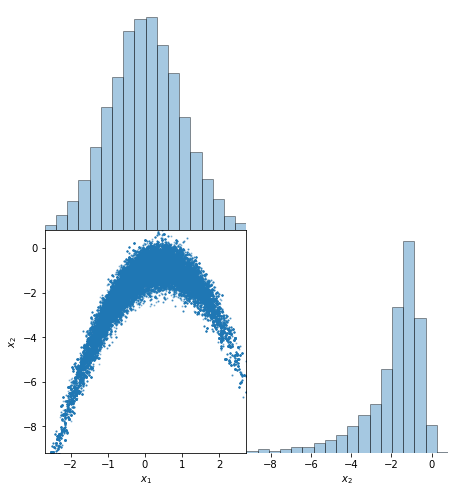

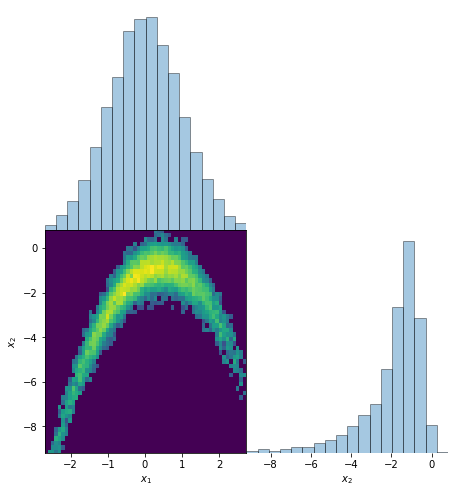

In [17]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

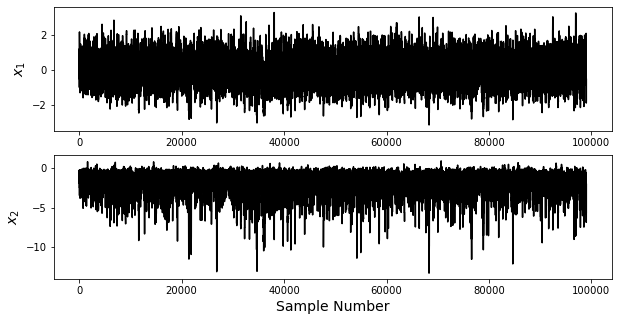

In [18]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation

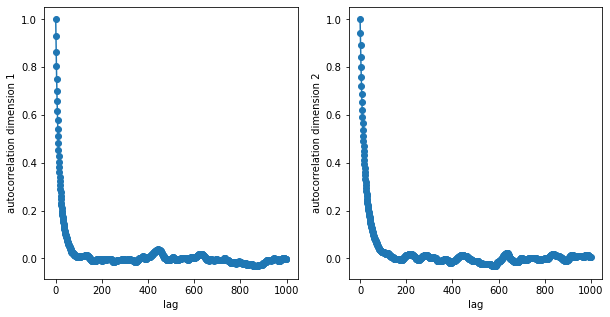

In [19]:
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

### Compute IAC

In [20]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
print("IAC(x):", IACx)
print("IAC(y):", IACy)

IAC(x): 28.96347400080048
IAC(y): 45.344327157493666


### Compute ESS

In [21]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)

ESS(x): 3452.624502062019
ESS(y): 2205.347532287153


## 1-3 Delayed Rejection

The algorithm of this section is similar to the ordinary MH-MCMC discussed in previous section. The only difference is we implement the second level of acceptance rate calculation to increase the overall acceptance rate of the simulation.

The idea of delayed rejection is, when being rejected, instead of advancing time and retaining the same position, a second stage move is proposed.

For a random walk proposal,
\begin{equation}
    a_1(x, y) = \min \left(1, \frac{f_X(y)}{f_X(x)} \right)
\end{equation}

if rejected, propose $y_2 \sim q_2 (y_2|x, y_1)$. According to Mira 2001, for symmetric proposals (e.g. random walk proposal), the second stage of acceptance probability is

\begin{equation}
a_2(x, y) = \min\left\{ 1, \frac{ \max\left\{ 0, f_X(y_2) - f_X(y_1) \right\}}{f_X(x) - f_X(y_1)}\right\}
\end{equation}

For this problem, $\gamma = \frac{1}{2}$ is used to scale the second level proposal covariance. Given $C$ as the first level proposal distribution, $\gamma C$ is used as the second level proposal covariance.


In [22]:
def mh_acceptance_prob_level2(current_target_logpdf, proposed_target_logpdf1, proposed_target_logpdf2):
    """Compute the metropolis-hastings accept-reject probability: level 2
    
    Inputs
    ------
    current_target_logpdf : float, logpdf at the current sample in the chain f_X(x^{(k)})
    proposed_target_logpdf : float, logpdf at the proposed sample in the chain
    
    
    Returns
    -------
    acceptance probability
    """
    px  = np.exp(current_target_logpdf)
    py1 = np.exp(proposed_target_logpdf1)
    py2 = np.exp(proposed_target_logpdf2)
    
    if py2 > px:
        return 1
    
    elif py2 < py1:
        return 0
    
    elif px > py2 and py2 >= py1:
        return (py2 - py1)/(px - py1)
    
    else:
        return 0
    

In [23]:
def DRmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, gamma=0.5, init_cov=3e-1**2):
    """Delay Rejection Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    I_d = np.eye(d)
    sd = 2.4**2/d
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
        
    if np.size(init_cov) == 1:
        sk = init_cov*I_d # covarance
    else:
        sk = sd*init_cov
    sk_chol = np.linalg.cholesky(sk)
    proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], sk_chol)
        proposed_target_logpdf = target_logpdf(proposed_sample)
        
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf_given_cov)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # stage 2 of acceptance probability
                proposed_sample2 = proposal_sampler(samples[ii-1, :], gamma*sk_chol)
                proposed_target_logpdf2 = target_logpdf(proposed_sample2)
                a2 = mh_acceptance_prob_level2(current_target_logpdf, proposed_target_logpdf, proposed_target_logpdf2)
                u2 = np.random.rand()
                if u2 < a2: # accept stage 2
                    samples[ii, :] = proposed_sample2
                    current_target_logpdf = proposed_target_logpdf2
                    num_accept += 1
                else: # begin rejected by both stage
                    samples[ii, :] = samples[ii-1, :]
                
    return samples, num_accept / float(num_samples-1)

In [24]:
num_samples = 100000
dim = 2
initial_guess = np.random.randn(2) # random location
target_logpdf = banana_logpdf
[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)

samples, ar = DRmcmc(initial_sample, num_samples, banana_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)

samples = samples[BURN_IN:, :]

Accepted Samples Ratio: 0.5201052010520105


### Visualization

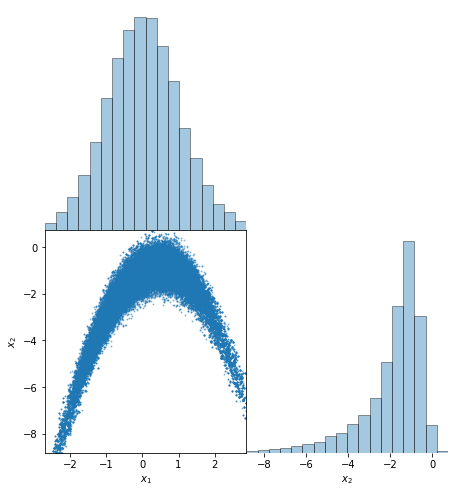

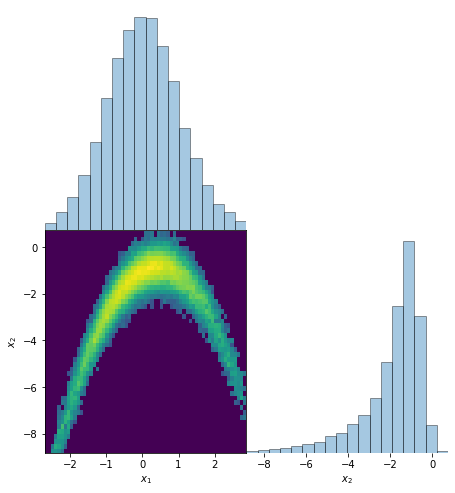

In [25]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

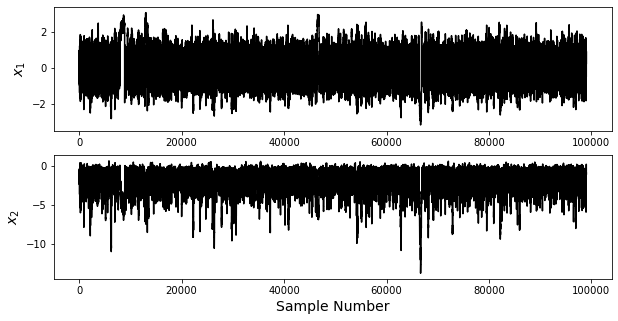

In [26]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation

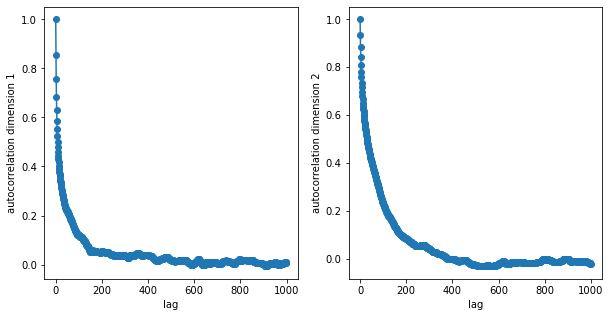

In [27]:
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

### Compute IAC

In [28]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
print("IAC(x):", IACx)
print("IAC(y):", IACy)

IAC(x): 99.27778779276
IAC(y): 113.73475350231827


### Compute ESS

In [29]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)

ESS(x): 1007.2746605589924
ESS(y): 879.2387280107982


## 1-4 DRAM MCMC

This algorithm is the combination of both Delayed-Rejection (DR) and Adaptive Metropolis (AM).

In [30]:
def DRAMmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, t0=100, freq=1, gamma=0.5, init_cov=3e-1**2):
    """Delayed Rejection Adaptive Metropolis MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    t0: integer, start adapting metropolis t0-th step.
    freq: integer, the frequency to adapt metropolis
    
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """
    xi = 0.001
    d = starting_sample.shape[0]
    I_d = np.eye(d)
    sd = 2.4**2/d
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    
    mean_curr = np.reshape(starting_sample, [d, 1]) # mean
    if np.size(init_cov) == 1:
        sk = init_cov*I_d # covarance
    else:
        sk = sd*init_cov
    sk_chol = np.linalg.cholesky(sk)
    proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)
    current_target_logpdf = target_logpdf(samples[0, :])
    
    num_accept = 0
    
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], sk_chol)
        proposed_target_logpdf = target_logpdf(proposed_sample)
        
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf_given_cov)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # stage 2 of acceptance probability
                proposed_sample2 = proposal_sampler(samples[ii-1, :], gamma*sk_chol)
                proposed_target_logpdf2 = target_logpdf(proposed_sample2)
                a2 = mh_acceptance_prob_level2(current_target_logpdf, proposed_target_logpdf, proposed_target_logpdf2)
                u2 = np.random.rand()
                if u2 < a2: # accept stage 2
                    samples[ii, :] = proposed_sample2
                    current_target_logpdf = proposed_target_logpdf2
                    num_accept += 1
                else: # begin rejected by both stage
                    samples[ii, :] = samples[ii-1, :]
                
        # adapt covariance
        xk = (samples[ii, :])[:, np.newaxis]
        mean_prev = mean_curr
        mean_curr = 1/(ii + 1)*xk + ii/(ii + 1)*mean_prev
        sk = (ii-1)/ii * sk + \
             sd/ii * (xi * I_d + \
                      ii * np.matmul(mean_prev, mean_prev.T) - \
                      (ii + 1) * np.matmul(mean_curr, mean_curr.T) + \
                      np.matmul(xk, xk.T))
        
        if ii > t0 and ii % freq == 0:
            sk_chol = np.linalg.cholesky(sk)
            proposal_logpdf_given_cov = lambda x, y: proposal_logpdf(x, y, sk)

        if ii % 1000 == 0:
            print(f"Finished sample {ii}, acceptance ratio = {num_accept / ii}")
                
    return samples, num_accept / float(ii)

In [31]:
num_samples = 100000
dim = 2
initial_guess = np.random.randn(2) # random location
target_logpdf = banana_logpdf
[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)

samples, ar = DRAMmcmc(initial_sample, num_samples, banana_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)

samples = samples[BURN_IN:, :]

Finished sample 1000, acceptance ratio = 0.562
Finished sample 2000, acceptance ratio = 0.508
Finished sample 3000, acceptance ratio = 0.479
Finished sample 4000, acceptance ratio = 0.47525
Finished sample 5000, acceptance ratio = 0.4656
Finished sample 6000, acceptance ratio = 0.4523333333333333
Finished sample 7000, acceptance ratio = 0.44842857142857145
Finished sample 8000, acceptance ratio = 0.44275
Finished sample 9000, acceptance ratio = 0.441
Finished sample 10000, acceptance ratio = 0.4404
Finished sample 11000, acceptance ratio = 0.4390909090909091
Finished sample 12000, acceptance ratio = 0.435
Finished sample 13000, acceptance ratio = 0.4316923076923077
Finished sample 14000, acceptance ratio = 0.4287142857142857
Finished sample 15000, acceptance ratio = 0.4254
Finished sample 16000, acceptance ratio = 0.4230625
Finished sample 17000, acceptance ratio = 0.42270588235294115
Finished sample 18000, acceptance ratio = 0.41994444444444445
Finished sample 19000, acceptance ratio 

### Visualization

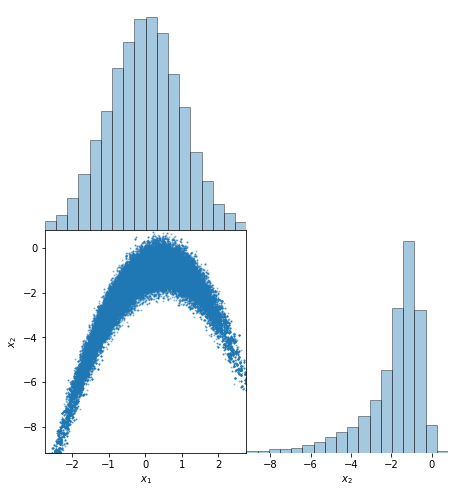

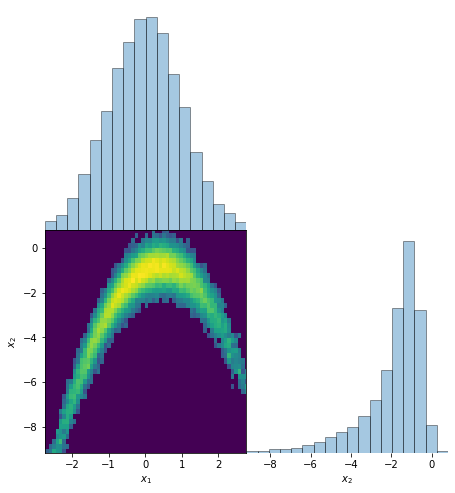

In [32]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

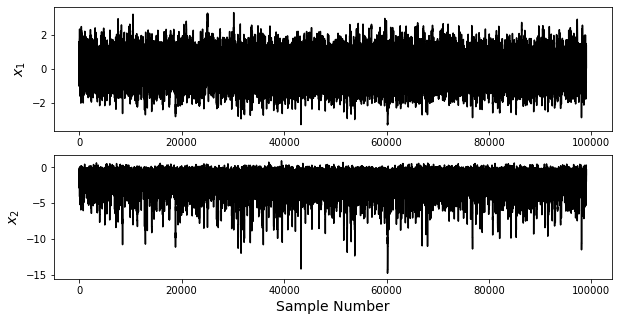

In [33]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation

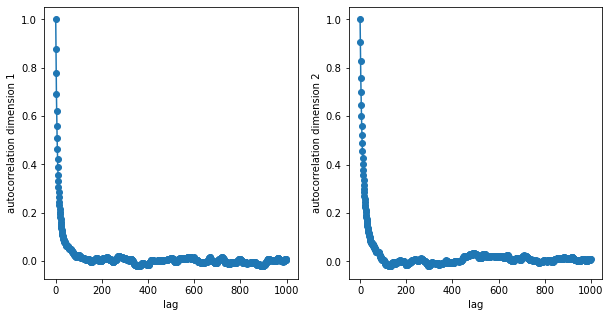

In [34]:
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

### Compute IAC

In [35]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
print("IAC(x):", IACx)
print("IAC(y):", IACy)

IAC(x): 31.786287918722092
IAC(y): 46.30765201142681


### Compute ESS

In [36]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)

ESS(x): 3146.010640050237
ESS(y): 2159.470317677177


# 2. Second Example: SIR Model

In this section, we set up the truth model for a deterministic system.

## 2.1 Identifiable Version

The identifiable version of SIR model are given:

\begin{equation}\label{eqn:SIR_ID}
    \begin{cases}
      \frac{dS}{dt} = \delta N - \delta S - \beta IS\\
      \frac{dI}{dt} = \beta IS - (r + \delta) I\\
      \frac{dR}{dt} = rI - \delta R
    \end{cases}
\end{equation}

where $N$ is the total population, in our case $N = 1000$, and the initial conditions are $S(0) = 900; I(0) = 100; R(0) = 0$. Here, we use scipy.integrate.solve_ivp to integrate Equation above between $t \in [0, 6]$ using "True" parameter settings

\begin{equation}
    \theta = \left(\beta, r, \delta \right) =  \left(0.02, 0.6, 0.15\right)
\end{equation}

In [37]:
BETA1 = 0.02
R1 = 0.6
DELTA1 = 0.15
N = 1000

In [38]:
def ODEs(t, y): 
    # t: time
    # y: [S(t), I(t), R(t)]
    dydt = np.array([(DELTA1*N - DELTA1*y[0] - BETA1*y[1]*y[0]),
                     (BETA1*y[1]*y[0] - (R1 + DELTA1)*y[1]),
                     (R1*y[1] - DELTA1*y[2])])
    return dydt

In [39]:
def SIR_Solver(t, y0, ODEs):
    
    y_ = solve_ivp(ODEs, [t[0], t[-1]], y0, t_eval=t)
    
    return y_.y

### Integrating the SIR model
Integrating the SIR model with given the initial conditions and the "true" parameters. The measurements of $I$ are corrupted by zero mean noise with standard deviation, i.e.

\begin{equation}\label{eqn:I_meas}
    I_{measure}(t) = I(t) + \eta, where\ \eta \sim N(0, 50^2)
\end{equation} 

Therefore, $I_{measure}(t) \sim N(I(t), 50^2)$ and is visualized below. We will use this fact to build the posterior function.

In [40]:
t = np.linspace(0, 6, 61)
y0 = [900, 100, 0]
y_ = SIR_Solver(t, y0, ODEs)

S_id = y_[0]
I_id = y_[1]
R_id = y_[2]

I_id_meas = I_id + 50*np.random.randn(61)

### Visualization

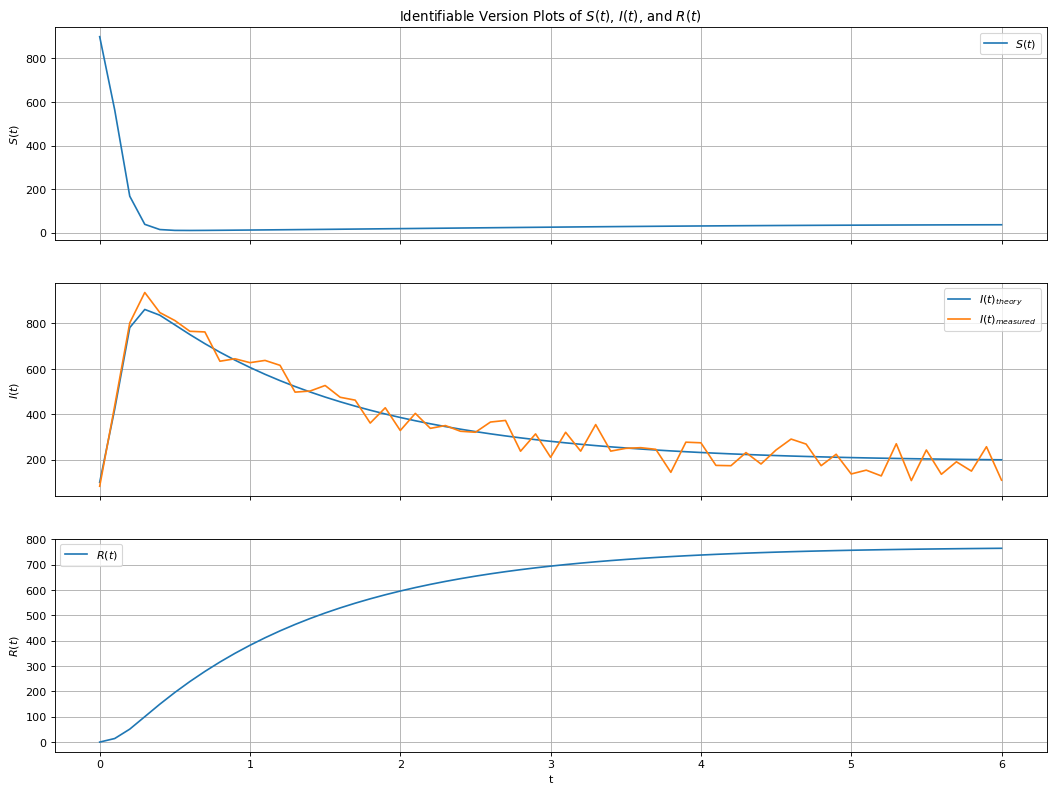

In [41]:
fig = plt.figure(figsize=(16, 12), dpi=80)
ax1 = plt.subplot(311)
ax1.plot(t, S_id, label=r'$S(t)$')
ax1.set_ylabel(r'$S(t)$')
ax1.set_title(r'Identifiable Version Plots of $S(t)$, $I(t)$, and $R(t)$')
ax1.grid()
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex = ax1)
ax2.plot(t, I_id, label=r'$I(t)_{theory}$')
ax2.plot(t, I_id_meas, label=r'$I(t)_{measured}$')
ax2.set_ylabel(r'$I(t)$')
ax2.grid()
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex = ax1)
ax3.plot(t, R_id, label=r'$R(t)$')
ax3.set_xlabel('t')
ax3.set_ylabel(r'$R(t)$')
ax3.grid()
ax3.legend()
plt.show()

## 2.2  Non-Identifiable Version
The non-identifiable version of SIR model are given:

\begin{equation}\label{eqn:SIR_nonID}
    \begin{cases}
      \frac{dS}{dt} = \delta N - \delta S - \gamma\kappa IS\\
      \frac{dI}{dt} = \gamma\kappa IS - (r + \delta) I\\
      \frac{dR}{dt} = rI - \delta R
    \end{cases}
\end{equation}

where $N$ is the total population, in our case $N = 1000$, and the initial conditions are $S(0) = 900; I(0) = 100; R(0) = 0$. Here, we use scipy.integrate.solve_ivp to integrate Equation above between $t \in [0, 6]$ using "True" parameter settings

\begin{equation}
    \theta = \left(\gamma, \kappa, r, \delta \right) =  \left(0.2, 0.1, 0.6, 0.15\right)
\end{equation}

The results are visualized below with $I_{measure}(t)$, which uses the identical noise used in identifiable version. 

In [42]:
GAMMA2 = 0.2
KAPPA2 = 0.1
R2 = 0.6
DELTA2 = 0.15

In [43]:
def ODEs_nonid(t, y): 
    # Non-identifiable version
    # t: time
    # y: [S(t), I(t), R(t)]
    dydt = np.array([(DELTA2*N - DELTA2*y[0] - GAMMA2*KAPPA2*y[1]*y[0]),
                     (GAMMA2*KAPPA2*y[1]*y[0] - (R2 + DELTA2)*y[1]),
                     (R2*y[1] - DELTA2*y[2])])
    return dydt

### Integrating the SIR model

In [44]:
t = np.linspace(0, 6, 61)
y0 = [900, 100, 0]
y_ = SIR_Solver(t, y0, ODEs_nonid)

S_nonid = y_[0]
I_nonid = y_[1]
R_nonid = y_[2]

I_nonid_meas = I_nonid + 50*np.random.randn(61)

### Visualization

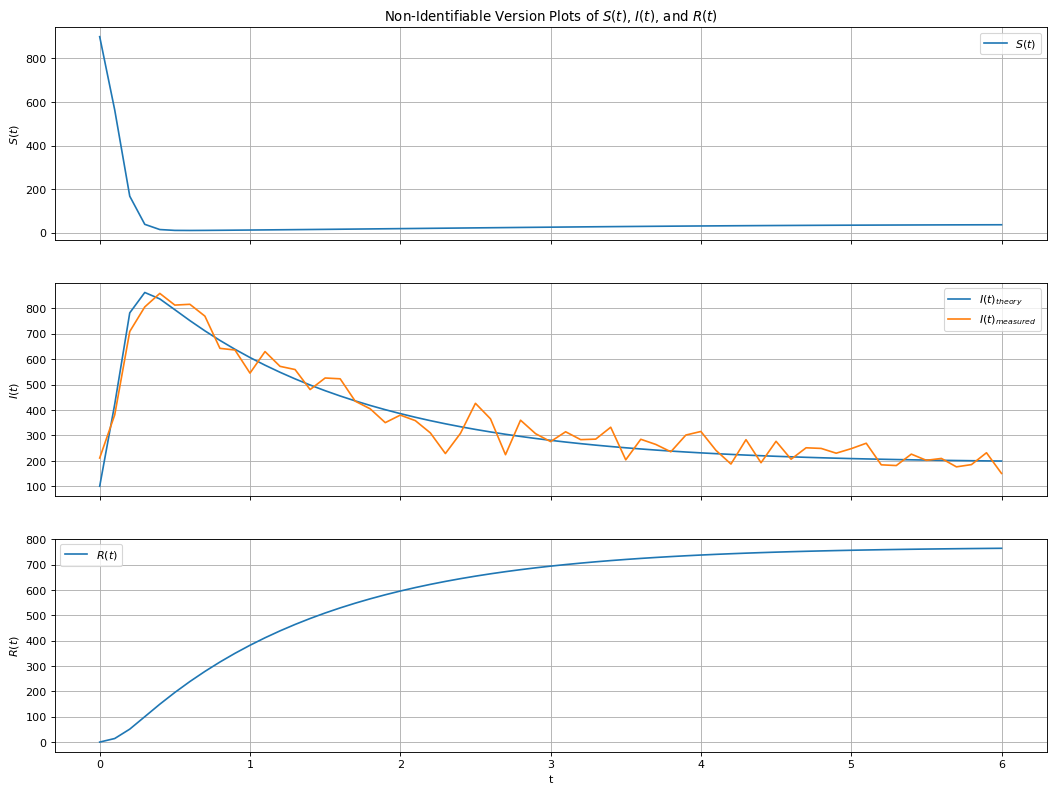

In [45]:
fig = plt.figure(figsize=(16, 12), dpi=80)
ax1 = plt.subplot(311)
ax1.plot(t, S_nonid, label=r'$S(t)$')
ax1.set_ylabel(r'$S(t)$')
ax1.set_title(r'Non-Identifiable Version Plots of $S(t)$, $I(t)$, and $R(t)$')
ax1.grid()
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex = ax1)
ax2.plot(t, I_nonid, label=r'$I(t)_{theory}$')
ax2.plot(t, I_nonid_meas, label=r'$I(t)_{measured}$')
ax2.set_ylabel(r'$I(t)$')
ax2.grid()
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex = ax1)
ax3.plot(t, R_nonid, label=r'$R(t)$')
ax3.set_xlabel('t')
ax3.set_ylabel(r'$R(t)$')
ax3.grid()
ax3.legend()
plt.show()

## 2.3 Estimate parameters of SIR model with DRAM-MCMC
### likelihood function:

From Bayesian Theorem

\begin{equation}\label{eqn:bayes}
    f_{\theta|d}(\theta|d) = \frac{f_{d|\theta}(d|\theta)}{f_d(d)} f_{\theta}(\theta)  \propto f_{d|\theta}(d|\theta) f_{\theta}(\theta)
\end{equation}

Each data points at $t_i$ centers at $I(t)$ according to $f_{d_{t_i}|\theta}(d_{t_i}|\theta) \sim N(I(t_i), 50^2) $. This yields the conditional independence between $f_{d_{t_i}|\theta}(d_{t_i}|\theta)$ at different time $t_i$. Therefore, the system likelihood is

\begin{equation}\label{eqn:likelihood}
    f_{d|\theta}(d|\theta) = \prod_{t_i=1}^{61} f_{d_{t_i}|\theta}(d_{t_i}|\theta)
\end{equation}

We should also note that, since $\theta \in \mathbf{R^+}^{dim}$, if any component of $\theta <0$ exists, the likelihood should be zero.

### Posterior:

According to previous two equations, we obtain the posterior:

\begin{equation}\label{eqn:posterior}
    f_{\theta|d}(\theta|d) \propto f_{\theta}(\theta)\prod_{t_i=1}^{61} f_{d_{t_i}|\theta}(d_{t_i}|\theta)
\end{equation}

In this project, we use log of the posterior as the target function of MCMC. Since $f_{d_{t_i}|\theta}(d_{t_i}|\theta) \sim N(I(t), 50^2)$ and $f_{\theta}(\theta) \sim N(0, 1)$, then the posterior becomes:
\begin{equation}\label{eqn:logposterior}
    \log{(f_{\theta|d}(\theta|d))} \propto -0.5\sum_{j=1}^{dim} \theta_j^2 - 0.5\sum_{t_i=1}^{61} \left( \frac{I_{measure}(t_i) - I(t_i)}{50} \right)^2
\end{equation}

## 2.3.1 Identifiable Version
### Posterior

In [46]:
def SIR_logpdf(theta, std_theta, I, I_meas, std_I):
    
    num_meas = (np.shape(I_meas))[0]
    
    log_sqrt_2pi = 0.5*np.log(2*np.pi)
    log_normal = lambda x, mu, sigma: -np.log(sigma)-log_sqrt_2pi-0.5*((x-mu)/sigma)**2
    
    if np.any(theta<0):
        log_likelihood = -1e20
    
    else:
        log_likelihood = log_normal(I_meas, I(theta), std_I)
        log_likelihood = np.sum(log_likelihood)
    
    log_p_theta = log_normal(theta, 0, std_theta)
    log_p_theta = np.sum(log_p_theta)
    
    return log_p_theta + log_likelihood

In [47]:
def ODEs_with_theta(t, y, theta): 
    # t: time
    # y: [S(t), I(t), R(t)]
    # theta: [beta, r, delta]
    
    dydt = np.array([(theta[2]*N - theta[2]*y[0] - theta[0]*y[1]*y[0]),
                     (theta[0]*y[1]*y[0] - (theta[1] + theta[2])*y[1]),
                     (theta[1]*y[1] - theta[2]*y[2])])
    return dydt

In [48]:
def ODEs_nonid_with_theta(t, y, theta): 
    # Non-identifiable version
    # t: time
    # y: [S(t), I(t), R(t)]
    # theta: [gamma, kappa, r, delta]
    
    dydt = np.array([(theta[3]*N - theta[3]*y[0] - theta[0]*theta[1]*y[1]*y[0]),
                     (theta[0]*theta[1]*y[1]*y[0] - (theta[2] + theta[3])*y[1]),
                     (theta[2]*y[1] - theta[3]*y[2])])
    return dydt

In [49]:
def I_solver_with_theta(theta, t, y0, ODEs):
    
    ODEs_given_theta = lambda t, y: ODEs(t, y, theta=theta)
    
    y_ = solve_ivp(ODEs_given_theta, [t[0], t[-1]], y0, t_eval=t)
    return y_.y[1]

### Laplace approximation

In [50]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

### DRAM-MCMC

In [51]:
num_samples = 100000
dim = 3
initial_guess = np.random.rand(dim) # random guess

t = np.linspace(0, 6, 61)
y0 = [900, 100, 0]
I_of_theta = lambda theta: I_solver_with_theta(theta, t=t, y0=y0, ODEs=ODEs_with_theta)
target_logpdf = lambda theta: SIR_logpdf(theta, std_theta=1, I=I_of_theta, I_meas=I_id_meas, std_I=50)
[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)
print(initial_sample)

samples, ar = DRAMmcmc(initial_sample, num_samples, target_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)

samples = samples[BURN_IN:, :]

[0.56173829 0.52164394 0.09361539]
Finished sample 1000, acceptance ratio = 0.089
Finished sample 2000, acceptance ratio = 0.046
Finished sample 3000, acceptance ratio = 0.03233333333333333
Finished sample 4000, acceptance ratio = 0.028
Finished sample 5000, acceptance ratio = 0.0234
Finished sample 6000, acceptance ratio = 0.020666666666666667
Finished sample 7000, acceptance ratio = 0.019142857142857142
Finished sample 8000, acceptance ratio = 0.018
Finished sample 9000, acceptance ratio = 0.017555555555555557
Finished sample 10000, acceptance ratio = 0.0166
Finished sample 11000, acceptance ratio = 0.016454545454545454
Finished sample 12000, acceptance ratio = 0.015916666666666666
Finished sample 13000, acceptance ratio = 0.015769230769230768
Finished sample 14000, acceptance ratio = 0.01507142857142857
Finished sample 15000, acceptance ratio = 0.014733333333333333
Finished sample 16000, acceptance ratio = 0.01475
Finished sample 17000, acceptance ratio = 0.014764705882352942
Finish

In [52]:
print(np.mean(samples, axis=0))

[0.021037   0.55626888 0.11482494]


### Marginal distributions of samples

Text(0.5, 1.0, '$\\delta$')

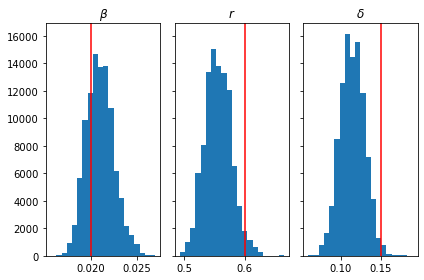

In [53]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(samples[:, 0], bins=20)
axs[0].axvline(x=0.02, c='r')
axs[0].set_title(r'$\beta$')
axs[1].hist(samples[:, 1], bins=20)
axs[1].axvline(x=0.6, c='r')
axs[1].set_title(r'$r$')
axs[2].hist(samples[:, 2], bins=20)
axs[2].axvline(x=0.15, c='r')
axs[2].set_title(r'$\delta$')

### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

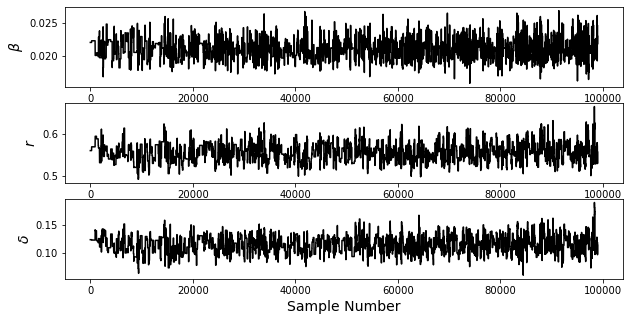

In [54]:
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\beta$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$r$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$\delta$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation

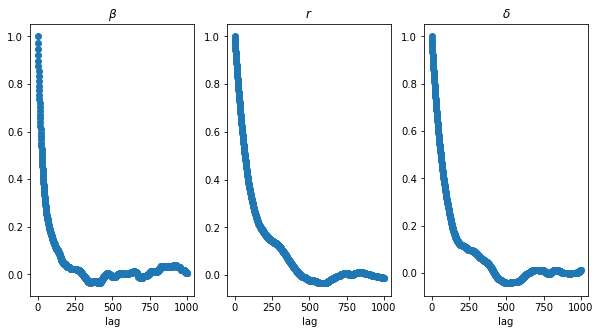

In [55]:
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_title(r'$\beta$')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_title(r'$r$')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_title(r'$\delta$')
plt.show()

### Compute IAC

In [56]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
IACz = 1 + 2 * np.sum(autolag[:, 2])
print("IAC(x):", IACx)
print("IAC(y):", IACy)
print("IAC(z):", IACz)

IAC(x): 105.57538160862268
IAC(y): 214.60040976458458
IAC(z): 182.46012485353313


### Compute ESS

In [57]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
ESSz = num_samples/IACz
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)
print("ESS(z):", ESSz)

ESS(x): 947.1905142688368
ESS(y): 465.9823348412961
ESS(z): 548.0649543579638


## 2.3.2 Non-identifiable Version
### DRAM-MCMC

In [58]:
num_samples = 100000
dim = 4
initial_guess = np.random.rand(dim) # random guess

t = np.linspace(0, 6, 61)
y0 = [900, 100, 0]
I_of_theta = lambda theta: I_solver_with_theta(theta, t=t, y0=y0, ODEs=ODEs_nonid_with_theta)
target_logpdf = lambda theta: SIR_logpdf(theta, std_theta=1, I=I_of_theta, I_meas=I_id_meas, std_I=50)
[initial_sample, initial_cov] = laplace_approx(initial_guess, target_logpdf)
print(initial_sample)

samples, ar = DRAMmcmc(initial_sample, num_samples, target_logpdf, 
                     proposal_rw_logpdf_with_cov, proposal_rw_sampler_with_cov, init_cov=initial_cov)

print("Accepted Samples Ratio:", ar)
samples = samples[BURN_IN:, :]

[0.65170255 0.65166866 0.52208298 0.09384982]
Finished sample 1000, acceptance ratio = 0.114
Finished sample 2000, acceptance ratio = 0.0645
Finished sample 3000, acceptance ratio = 0.050666666666666665
Finished sample 4000, acceptance ratio = 0.03975
Finished sample 5000, acceptance ratio = 0.0326
Finished sample 6000, acceptance ratio = 0.030666666666666665
Finished sample 7000, acceptance ratio = 0.03014285714285714
Finished sample 8000, acceptance ratio = 0.030125
Finished sample 9000, acceptance ratio = 0.029333333333333333
Finished sample 10000, acceptance ratio = 0.0284
Finished sample 11000, acceptance ratio = 0.026727272727272728
Finished sample 12000, acceptance ratio = 0.02625
Finished sample 13000, acceptance ratio = 0.025538461538461538
Finished sample 14000, acceptance ratio = 0.02492857142857143
Finished sample 15000, acceptance ratio = 0.024133333333333333
Finished sample 16000, acceptance ratio = 0.0231875
Finished sample 17000, acceptance ratio = 0.022823529411764704


In [59]:
print(np.mean(samples[:, :], axis=0))

[0.17359173 0.41981729 0.55742911 0.11584249]


### Marginal distributions of samples

Text(0.5, 1.0, '$\\delta$')

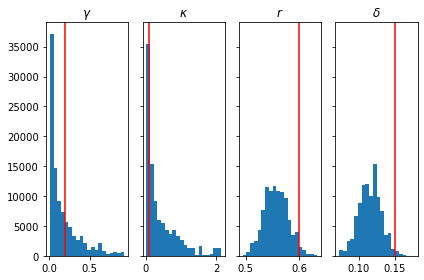

In [60]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(samples[:, 0], bins=20)
axs[0].axvline(x=0.2, c='r')
axs[0].set_title(r'$\gamma$')
axs[1].hist(samples[:, 1], bins=20)
axs[1].axvline(x=0.1, c='r')
axs[1].set_title(r'$\kappa$')
axs[2].hist(samples[:, 2], bins=20)
axs[2].axvline(x=0.6, c='r')
axs[2].set_title(r'$r$')
axs[3].hist(samples[:, 3], bins=20)
axs[3].axvline(x=0.15, c='r')
axs[3].set_title(r'$\delta$')

### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

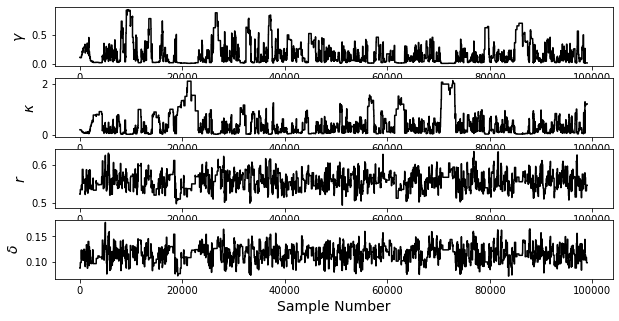

In [61]:
fig, axs = plt.subplots(4,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\gamma$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$\kappa$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$r$', fontsize=14)
axs[3].plot(samples[:, 3], '-k')
axs[3].set_ylabel(r'$\delta$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation

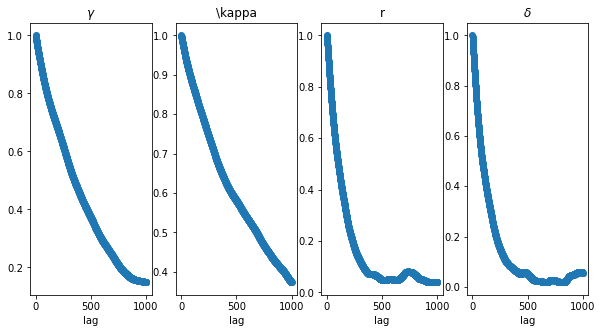

In [62]:
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_title(r'$\gamma$')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_title(r'\kappa')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_title('r')
axs[3].plot(lags, autolag[:, 3],'-o')
axs[3].set_xlabel('lag')
axs[3].set_title(r'$\delta$')
plt.show()

### Compute IAC

In [63]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
IACz = 1 + 2 * np.sum(autolag[:, 2])
IACw = 1 + 2 * np.sum(autolag[:, 3])
print("IAC(x):", IACx)
print("IAC(y):", IACy)
print("IAC(z):", IACz)
print("IAC(w):", IACw)

IAC(x): 858.2785430621109
IAC(y): 1227.6712562937535
IAC(z): 341.76383281301094
IAC(w): 297.7861158075642


### Compute ESS

In [64]:
ESSx = num_samples/IACx
ESSy = num_samples/IACy
ESSz = num_samples/IACz
ESSw = num_samples/IACw
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)
print("ESS(z):", ESSz)
print("ESS(w):", ESSw)

ESS(x): 116.51229173599802
ESS(y): 81.45503080514602
ESS(z): 292.5997147706175
ESS(w): 335.8114925164011


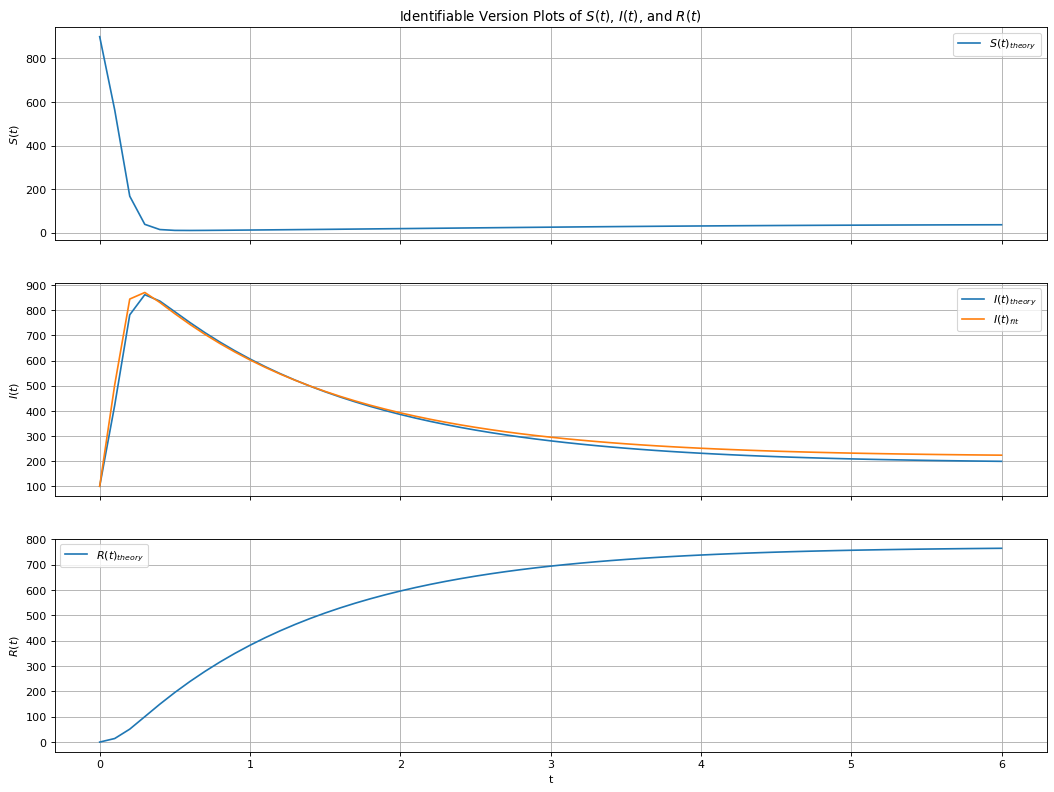

In [65]:
BETA1 = 0.02344556 
R1 = 0.60388435
DELTA1 = 0.17580596
N = 1000

def ODEs(t, y): 
    # t: time
    # y: [S(t), I(t), R(t)]
    dydt = np.array([(DELTA1*N - DELTA1*y[0] - BETA1*y[1]*y[0]),
                     (BETA1*y[1]*y[0] - (R1 + DELTA1)*y[1]),
                     (R1*y[1] - DELTA1*y[2])])
    return dydt

def SIR_Solver(t, y0, ODEs):
    
    y_ = solve_ivp(ODEs, [t[0], t[-1]], y0, t_eval=t)
    
    return y_.y


t = np.linspace(0, 6, 61)
y0 = [900, 100, 0]
y_ = SIR_Solver(t, y0, ODEs)

S_id_fit = y_[0]
I_id_fit = y_[1]
R_id_fit = y_[2]

BETA1 = 0.02
R1 = 0.6
DELTA1 = 0.15
N = 1000
y_ = SIR_Solver(t, y0, ODEs)
S_id = y_[0]
I_id = y_[1]
R_id = y_[2]



I_id_meas = I_id + 50*np.random.randn(61)

fig = plt.figure(figsize=(16, 12), dpi=80)
ax1 = plt.subplot(311)
ax1.plot(t, S_id, label=r'$S(t)_{theory}$')
ax1.set_ylabel(r'$S(t)$')
ax1.set_title(r'Identifiable Version Plots of $S(t)$, $I(t)$, and $R(t)$')
ax1.grid()
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex = ax1)
ax2.plot(t, I_id, label=r'$I(t)_{theory}$')
ax2.plot(t, I_id_fit, label=r'$I(t)_{fit}$')
ax2.set_ylabel(r'$I(t)$')
ax2.grid()
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex = ax1)
ax3.plot(t, R_id, label=r'$R(t)_{theory}$')
ax3.set_xlabel('t')
ax3.set_ylabel(r'$R(t)$')
ax3.grid()
ax3.legend()
plt.show()